# 1. Define Concrete Dropout and Variational Dropout

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
class ConcreteDropout(nn.Module):
    def __init__(self, p_logit=-2.0, temp=0.1, eps=1e-8):
        super(ConcreteDropout, self).__init__()
        self.p_logit = nn.Parameter(torch.Tensor([p_logit]))
        self.temp = temp
        self.eps = eps
        
    @property
    def p(self):
        return torch.sigmoid(self.p_logit)
        
    def forward(self, x):
        if self.train():
            unif_noise = torch.rand_like(x)
            drop_prob = torch.log(self.p + self.eps) -\
            torch.log(1-self.p + self.eps)+\
            torch.log(unif_noise + self.eps)-\
            torch.log(1-unif_noise + self.eps)
            drop_prob = torch.sigmoid(drop_prob/ self.temp)
            random_tensor = 1. - drop_prob
            retain_prob = 1. - self.p
            x *= random_tensor
            x /= retain_prob
        return x

In [3]:
cdrop = ConcreteDropout()
drop = nn.Dropout()
input = torch.ones([1,10])
output1 = cdrop(input)
input = torch.ones([1,10])
output2 = drop(input)
print(output1)
print(output2)

tensor([[1.1353, 1.1353, 1.1353, 1.1277, 0.4872, 1.1353, 1.1353, 1.1353, 1.1353,
         1.1353]], grad_fn=<DivBackward0>)
tensor([[0., 0., 2., 2., 2., 2., 2., 0., 0., 0.]])


In [4]:
class VariationalDropout(nn.Module):
    def __init__(self, log_alpha=-3.):
        super(VariationalDropout, self).__init__()
        self.max_log_alpha = 0.0
        self.log_alpha = nn.Parameter(torch.Tensor([log_alpha]))
        
    @property
    def alpha(self):
        return torch.exp(self.log_alpha)
        
    def forward(self, x):
        if self.train():
            normal_noise = torch.randn_like(x)
            self.log_alpha.data = torch.clamp(self.log_alpha.data, max=self.max_log_alpha)
            random_tensor = 1. + normal_noise * torch.sqrt(self.alpha)
            x *= random_tensor
        return x

# 2. Loading and normalizing CIFAR-10

In [5]:
import torch
import torchvision
import torchvision.transforms as transforms

In [6]:
batch_size = 1000

train_transform = transforms.Compose(
    [transforms.RandomCrop(32, padding=4),
     transforms.RandomHorizontalFlip(),
     transforms.ToTensor(),
     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])

test_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=train_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=4)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=test_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=4)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
print('train set size: {}'.format(len(trainset)))
log_freq = len(trainset)//batch_size
print('log freq: {}'.format(log_freq))
print('test set size: {}'.format(len(testset)))

Files already downloaded and verified
Files already downloaded and verified
train set size: 50000
log freq: 50
test set size: 10000


In [7]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline

In [8]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1000, 3, 32, 32])


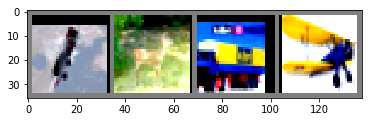

plane  deer truck plane


In [9]:
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
print(images.shape)

# show images
imshow(torchvision.utils.make_grid(images[:4]))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

# 3. Define Lenet with/without dropout

In [10]:
# Lenet with Concrete dropout
class Net_CDO(nn.Module):
    def __init__(self, weight_reg_coef=5e-4, dropout_reg_coef=1e-2):
        super(Net_CDO, self).__init__()
        self.conv1 = nn.Conv2d(3, 192, 5, padding=2)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(192, 192, 5, padding=2)
        self.fc1 = nn.Linear(192 * 8 * 8, 1024)
        self.fc2 = nn.Linear(1024, 256)
        self.fc3 = nn.Linear(256, 10)
        self.cdropout1 = ConcreteDropout()
        self.cdropout2 = ConcreteDropout()
        self.cdropout3 = ConcreteDropout()
        self.cdropout4 = ConcreteDropout()
        self.weight_reg_coef = weight_reg_coef
        self.dropout_reg_coef = dropout_reg_coef
        
        nn.init.xavier_uniform_(self.conv1.weight)
        nn.init.constant_(self.conv1.bias, 0.0)
        nn.init.xavier_uniform_(self.conv2.weight)
        nn.init.constant_(self.conv2.bias, 0.0)
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.constant_(self.fc1.bias, 0.0)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.constant_(self.fc2.bias, 0.0)
        nn.init.xavier_uniform_(self.fc3.weight)
        nn.init.constant_(self.fc3.bias, 0.0)

    def forward(self, x):
        x = self.pool(F.relu(self.cdropout1(self.conv1(x))))
        x = self.pool(F.relu(self.cdropout2(self.conv2(x))))
        x = x.view(-1, 192 * 8 * 8)
        x = F.relu(self.cdropout3(self.fc1(x)))
        x = F.relu(self.cdropout4(self.fc2(x)))
        x = F.softmax(self.fc3(x),dim=1)
        return x
    
    def entropy(self,cdropout):
        return -cdropout.p * torch.log(cdropout.p+1e-8) \
    -(1-cdropout.p) * torch.log(1-cdropout.p+1e-8)
    
    def calc_reg(self):
        weight_reg = (self.fc1.weight.norm()**2+self.fc1.bias.norm()**2)/(1-self.cdropout3.p)+\
        (self.fc2.weight.norm()**2+self.fc2.bias.norm()**2)/(1-self.cdropout4.p)+\
        (self.fc3.weight.norm()**2+self.fc3.bias.norm()**2)+\
        (self.conv1.weight.norm()**2+self.conv1.bias.norm()**2)/(1-self.cdropout1.p)+\
        (self.conv2.weight.norm()**2+self.conv2.bias.norm()**2)/(1-self.cdropout2.p)
        weight_reg *= self.weight_reg_coef
        dropout_reg = -self.entropy(self.cdropout1)-self.entropy(self.cdropout2)-\
        self.entropy(self.cdropout3)-self.entropy(self.cdropout4)
        dropout_reg *= self.dropout_reg_coef
        return weight_reg + dropout_reg
    
# Lenet with Variational dropout
class Net_VDO(nn.Module):
    def __init__(self, reg_coef=5e-4):
        super(Net_VDO, self).__init__()
        self.conv1 = nn.Conv2d(3, 192, 5, padding=2)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(192, 192, 5, padding=2)
        self.fc1 = nn.Linear(192 * 8 * 8, 1024)
        self.fc2 = nn.Linear(1024, 256)
        self.fc3 = nn.Linear(256, 10)
        self.vdropout1 = VariationalDropout()
        self.vdropout2 = VariationalDropout()
        self.vdropout3 = VariationalDropout()
        self.vdropout4 = VariationalDropout()
        self.reg_coef = reg_coef
        
        nn.init.xavier_uniform_(self.conv1.weight)
        nn.init.constant_(self.conv1.bias, 0.0)
        nn.init.xavier_uniform_(self.conv2.weight)
        nn.init.constant_(self.conv2.bias, 0.0)
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.constant_(self.fc1.bias, 0.0)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.constant_(self.fc2.bias, 0.0)
        nn.init.xavier_uniform_(self.fc3.weight)
        nn.init.constant_(self.fc3.bias, 0.0)

    def forward(self, x):
        x = self.pool(F.relu(self.vdropout1(self.conv1(x))))
        x = self.pool(F.relu(self.vdropout2(self.conv2(x))))
        x = x.view(-1, 192 * 8 * 8)
        x = F.relu(self.vdropout3(self.fc1(x)))
        x = F.relu(self.vdropout4(self.fc2(x)))
        x = F.softmax(self.fc3(x),dim=1)
        return x
    
    def kl_prior(self, vdropout):
        c1 = 1.16145124
        c2 = -1.50204118
        c3 = 0.58629921
        return -0.5*vdropout.log_alpha - c1*vdropout.alpha \
        - c2*vdropout.alpha**2 - c3*vdropout.alpha**3
    
    def calc_reg(self):
        return self.reg_coef * (self.kl_prior(self.vdropout1)+self.kl_prior(self.vdropout2)+\
                               self.kl_prior(self.vdropout3))
        
# Lenet with MCDO
class Net_MCDO(nn.Module):
    def __init__(self):
        super(Net_MCDO, self).__init__()
        self.conv1 = nn.Conv2d(3, 192, 5, padding=2)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(192, 192, 5, padding=2)
        self.fc1 = nn.Linear(192 * 8 * 8, 1024)
        self.fc2 = nn.Linear(1024, 256)
        self.fc3 = nn.Linear(256, 10)
        self.dropout = nn.Dropout(p=0.3)
        
        nn.init.xavier_uniform_(self.conv1.weight)
        nn.init.constant_(self.conv1.bias, 0.0)
        nn.init.xavier_uniform_(self.conv2.weight)
        nn.init.constant_(self.conv2.bias, 0.0)
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.constant_(self.fc1.bias, 0.0)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.constant_(self.fc2.bias, 0.0)
        nn.init.xavier_uniform_(self.fc3.weight)
        nn.init.constant_(self.fc3.bias, 0.0)


    def forward(self, x):
        x = self.pool(F.relu(self.dropout(self.conv1(x))))
        x = self.pool(F.relu(self.dropout(self.conv2(x))))
        x = x.view(-1, 192 * 8 * 8)
        x = F.relu(self.dropout(self.fc1(x)))
        x = F.relu(self.dropout(self.fc2(x)))
        x = F.softmax(self.fc3(x),dim=1)
        return x

# 4. Define a Loss function and optimizer

In [11]:
import torch.optim as optim

In [12]:
CE = nn.CrossEntropyLoss()

In [13]:
def train(epoch, net, optimizer, log_freq=log_freq, is_calc_reg=False):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = CE(outputs, labels)
        if is_calc_reg:
            loss += torch.sum(net.module.calc_reg())
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if (i+1) % log_freq == 0:    # print every 2000 mini-batches
            print('[Epoch : %d, Iter: %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / log_freq))
    return running_loss / log_freq

def test(net):
    print('Start test')
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    with torch.no_grad():
        for data in testloader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            output = 0
            for i in range(50):
                output += net(inputs)/10.
            output = torch.log(output)
            _, predicted = torch.max(output, 1)
            c = (predicted == labels).squeeze()
            for i in range(len(labels)):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1


    for i in range(10):
        print('Accuracy of %5s : %.2f %%' % (
            classes[i], 100 * class_correct[i] / class_total[i]))

    test_score = np.mean([100 * class_correct[i] / class_total[i] for i in range(10)])
    print(test_score)
    return test_score

In [14]:
from tqdm import tqdm_notebook

lenets = [Net_CDO, Net_VDO, Net_MCDO] 
epoch_num = 300
test_freq = 10
losses = list()
net_scores = list()
test_scores = list()
cdropout_history = list()
vdropout_history = list()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
is_train = True

# SAVE
def save(name, net):
    net_path = './model/'+name+'.pkl'
    net = net.cpu()
    torch.save(net.state_dict(), net_path)
    # Place it to GPU back
    net.to(device)
    return net
    
def load(name, net):
    net_path = './model/'+name+'.pkl'
    # LOAD
    net.load_state_dict(torch.load(net_path))
    # Place it to GPU
    net.to(device)
    return net

def main():
    for lenet in lenets:
        print(lenet.__name__)
        net = lenet()
        if torch.cuda.device_count() > 1:
            print("Let's use",torch.cuda.device_count(),"GPUs!")
            net = nn.DataParallel(net)
        net.to(device)
        
        if lenet.__name__ == 'Net_CDO':
            optimizer = optim.Adam(net.parameters(), lr=5e-4, amsgrad=True)
        else:
            optimizer = optim.Adam(net.parameters(), lr=5e-4, weight_decay=5e-4, amsgrad=True)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.97)
        
        for i in tqdm_notebook(range(epoch_num)):
            scheduler.step()
#             net.train()
            if lenet.__name__ == 'Net_CDO':
                loss_avg = train(epoch=i, net=net, optimizer=optimizer, is_calc_reg=True)
                cdropout_history.append((net.module.cdropout1.p.item(),\
                                         net.module.cdropout2.p.item(),
                                        net.module.cdropout3.p.item(),
                                        net.module.cdropout4.p.item()))
            elif lenet.__name__ == 'Net_VDO':
                loss_avg = train(epoch=i, net=net, optimizer=optimizer, is_calc_reg=True)
                vdropout_history.append((net.module.vdropout1.alpha.item(),\
                                         net.module.vdropout2.alpha.item(),
                                        net.module.vdropout3.alpha.item(),
                                        net.module.vdropout4.alpha.item()))
            else:
                loss_avg = train(epoch=i, net=net, optimizer=optimizer)
            losses.append(loss_avg)
            if (i+1) % test_freq == 0:
#                 net.eval()
                net_score = test(net)
                net_scores.append(net_score)
        save(lenet.__name__, net)

In [15]:
if is_train:
    main()

Net_CDO
Let's use 4 GPUs!


[Epoch : 1, Iter:    50] loss: 2.877
[Epoch : 2, Iter:    50] loss: 2.295
[Epoch : 3, Iter:    50] loss: 2.167
[Epoch : 4, Iter:    50] loss: 2.104
[Epoch : 5, Iter:    50] loss: 2.059
[Epoch : 6, Iter:    50] loss: 2.025
[Epoch : 7, Iter:    50] loss: 2.000
[Epoch : 8, Iter:    50] loss: 1.976
[Epoch : 9, Iter:    50] loss: 1.958
[Epoch : 10, Iter:    50] loss: 1.944
Start test
Accuracy of plane : 79.70 %
Accuracy of   car : 76.40 %
Accuracy of  bird : 45.80 %
Accuracy of   cat : 40.00 %
Accuracy of  deer : 46.10 %
Accuracy of   dog : 57.40 %
Accuracy of  frog : 70.40 %
Accuracy of horse : 76.10 %
Accuracy of  ship : 71.90 %
Accuracy of truck : 83.80 %
64.76
[Epoch : 11, Iter:    50] loss: 1.934
[Epoch : 12, Iter:    50] loss: 1.927
[Epoch : 13, Iter:    50] loss: 1.913
[Epoch : 14, Iter:    50] loss: 1.907
[Epoch : 15, Iter:    50] loss: 1.895
[Epoch : 16, Iter:    50] loss: 1.892
[Epoch : 17, Iter:    50] loss: 1.886
[Epoch : 18, Iter:    50] loss: 1.878
[Epoch : 19, Iter:    50] lo

[Epoch : 122, Iter:    50] loss: 1.713
[Epoch : 123, Iter:    50] loss: 1.714
[Epoch : 124, Iter:    50] loss: 1.713
[Epoch : 125, Iter:    50] loss: 1.713
[Epoch : 126, Iter:    50] loss: 1.712
[Epoch : 127, Iter:    50] loss: 1.712
[Epoch : 128, Iter:    50] loss: 1.710
[Epoch : 129, Iter:    50] loss: 1.710
[Epoch : 130, Iter:    50] loss: 1.709
Start test
Accuracy of plane : 89.90 %
Accuracy of   car : 93.10 %
Accuracy of  bird : 71.60 %
Accuracy of   cat : 64.40 %
Accuracy of  deer : 80.20 %
Accuracy of   dog : 73.00 %
Accuracy of  frog : 90.40 %
Accuracy of horse : 89.60 %
Accuracy of  ship : 88.50 %
Accuracy of truck : 89.00 %
82.97
[Epoch : 131, Iter:    50] loss: 1.709
[Epoch : 132, Iter:    50] loss: 1.708
[Epoch : 133, Iter:    50] loss: 1.706
[Epoch : 134, Iter:    50] loss: 1.707
[Epoch : 135, Iter:    50] loss: 1.707
[Epoch : 136, Iter:    50] loss: 1.707
[Epoch : 137, Iter:    50] loss: 1.705
[Epoch : 138, Iter:    50] loss: 1.707
[Epoch : 139, Iter:    50] loss: 1.705
[

[Epoch : 241, Iter:    50] loss: 1.679
[Epoch : 242, Iter:    50] loss: 1.680
[Epoch : 243, Iter:    50] loss: 1.679
[Epoch : 244, Iter:    50] loss: 1.679
[Epoch : 245, Iter:    50] loss: 1.680
[Epoch : 246, Iter:    50] loss: 1.678
[Epoch : 247, Iter:    50] loss: 1.678
[Epoch : 248, Iter:    50] loss: 1.679
[Epoch : 249, Iter:    50] loss: 1.679
[Epoch : 250, Iter:    50] loss: 1.678
Start test
Accuracy of plane : 88.30 %
Accuracy of   car : 92.50 %
Accuracy of  bird : 74.20 %
Accuracy of   cat : 67.60 %
Accuracy of  deer : 83.90 %
Accuracy of   dog : 76.00 %
Accuracy of  frog : 90.60 %
Accuracy of horse : 87.50 %
Accuracy of  ship : 91.20 %
Accuracy of truck : 89.40 %
84.12
[Epoch : 251, Iter:    50] loss: 1.678
[Epoch : 252, Iter:    50] loss: 1.677
[Epoch : 253, Iter:    50] loss: 1.678
[Epoch : 254, Iter:    50] loss: 1.678
[Epoch : 255, Iter:    50] loss: 1.678
[Epoch : 256, Iter:    50] loss: 1.678
[Epoch : 257, Iter:    50] loss: 1.678
[Epoch : 258, Iter:    50] loss: 1.678
[

[Epoch : 1, Iter:    50] loss: 2.182
[Epoch : 2, Iter:    50] loss: 2.075
[Epoch : 3, Iter:    50] loss: 2.020
[Epoch : 4, Iter:    50] loss: 1.980
[Epoch : 5, Iter:    50] loss: 1.935
[Epoch : 6, Iter:    50] loss: 1.908
[Epoch : 7, Iter:    50] loss: 1.884
[Epoch : 8, Iter:    50] loss: 1.865
[Epoch : 9, Iter:    50] loss: 1.853
[Epoch : 10, Iter:    50] loss: 1.837
Start test
Accuracy of plane : 75.20 %
Accuracy of   car : 75.50 %
Accuracy of  bird : 57.50 %
Accuracy of   cat : 33.80 %
Accuracy of  deer : 39.70 %
Accuracy of   dog : 63.20 %
Accuracy of  frog : 78.10 %
Accuracy of horse : 75.80 %
Accuracy of  ship : 85.10 %
Accuracy of truck : 76.40 %
66.03
[Epoch : 11, Iter:    50] loss: 1.824
[Epoch : 12, Iter:    50] loss: 1.820
[Epoch : 13, Iter:    50] loss: 1.804
[Epoch : 14, Iter:    50] loss: 1.798
[Epoch : 15, Iter:    50] loss: 1.792
[Epoch : 16, Iter:    50] loss: 1.783
[Epoch : 17, Iter:    50] loss: 1.776
[Epoch : 18, Iter:    50] loss: 1.769
[Epoch : 19, Iter:    50] lo

[Epoch : 121, Iter:    50] loss: 1.595
[Epoch : 122, Iter:    50] loss: 1.595
[Epoch : 123, Iter:    50] loss: 1.591
[Epoch : 124, Iter:    50] loss: 1.594
[Epoch : 125, Iter:    50] loss: 1.591
[Epoch : 126, Iter:    50] loss: 1.591
[Epoch : 127, Iter:    50] loss: 1.589
[Epoch : 128, Iter:    50] loss: 1.589
[Epoch : 129, Iter:    50] loss: 1.588
[Epoch : 130, Iter:    50] loss: 1.587
Start test
Accuracy of plane : 86.40 %
Accuracy of   car : 92.60 %
Accuracy of  bird : 74.20 %
Accuracy of   cat : 70.80 %
Accuracy of  deer : 79.20 %
Accuracy of   dog : 77.00 %
Accuracy of  frog : 88.90 %
Accuracy of horse : 83.20 %
Accuracy of  ship : 91.70 %
Accuracy of truck : 89.80 %
83.38
[Epoch : 131, Iter:    50] loss: 1.589
[Epoch : 132, Iter:    50] loss: 1.588
[Epoch : 133, Iter:    50] loss: 1.587
[Epoch : 134, Iter:    50] loss: 1.585
[Epoch : 135, Iter:    50] loss: 1.585
[Epoch : 136, Iter:    50] loss: 1.586
[Epoch : 137, Iter:    50] loss: 1.584
[Epoch : 138, Iter:    50] loss: 1.583
[

[Epoch : 241, Iter:    50] loss: 1.557
[Epoch : 242, Iter:    50] loss: 1.556
[Epoch : 243, Iter:    50] loss: 1.556
[Epoch : 244, Iter:    50] loss: 1.556
[Epoch : 245, Iter:    50] loss: 1.556
[Epoch : 246, Iter:    50] loss: 1.555
[Epoch : 247, Iter:    50] loss: 1.556
[Epoch : 248, Iter:    50] loss: 1.555
[Epoch : 249, Iter:    50] loss: 1.556
[Epoch : 250, Iter:    50] loss: 1.554
Start test
Accuracy of plane : 88.30 %
Accuracy of   car : 92.60 %
Accuracy of  bird : 77.60 %
Accuracy of   cat : 72.50 %
Accuracy of  deer : 84.70 %
Accuracy of   dog : 74.40 %
Accuracy of  frog : 89.60 %
Accuracy of horse : 88.70 %
Accuracy of  ship : 91.30 %
Accuracy of truck : 91.00 %
85.07000000000001
[Epoch : 251, Iter:    50] loss: 1.555
[Epoch : 252, Iter:    50] loss: 1.555
[Epoch : 253, Iter:    50] loss: 1.555
[Epoch : 254, Iter:    50] loss: 1.554
[Epoch : 255, Iter:    50] loss: 1.554
[Epoch : 256, Iter:    50] loss: 1.556
[Epoch : 257, Iter:    50] loss: 1.555
[Epoch : 258, Iter:    50] l

[Epoch : 1, Iter:    50] loss: 2.197
[Epoch : 2, Iter:    50] loss: 2.082
[Epoch : 3, Iter:    50] loss: 2.029
[Epoch : 4, Iter:    50] loss: 1.995
[Epoch : 5, Iter:    50] loss: 1.965
[Epoch : 6, Iter:    50] loss: 1.942
[Epoch : 7, Iter:    50] loss: 1.923
[Epoch : 8, Iter:    50] loss: 1.893
[Epoch : 9, Iter:    50] loss: 1.873
[Epoch : 10, Iter:    50] loss: 1.862
Start test
Accuracy of plane : 81.50 %
Accuracy of   car : 80.20 %
Accuracy of  bird : 39.80 %
Accuracy of   cat : 41.50 %
Accuracy of  deer : 45.70 %
Accuracy of   dog : 63.20 %
Accuracy of  frog : 67.20 %
Accuracy of horse : 76.10 %
Accuracy of  ship : 68.80 %
Accuracy of truck : 73.90 %
63.79
[Epoch : 11, Iter:    50] loss: 1.850
[Epoch : 12, Iter:    50] loss: 1.832
[Epoch : 13, Iter:    50] loss: 1.826
[Epoch : 14, Iter:    50] loss: 1.825
[Epoch : 15, Iter:    50] loss: 1.810
[Epoch : 16, Iter:    50] loss: 1.805
[Epoch : 17, Iter:    50] loss: 1.795
[Epoch : 18, Iter:    50] loss: 1.787
[Epoch : 19, Iter:    50] lo

[Epoch : 123, Iter:    50] loss: 1.623
[Epoch : 124, Iter:    50] loss: 1.624
[Epoch : 125, Iter:    50] loss: 1.623
[Epoch : 126, Iter:    50] loss: 1.623
[Epoch : 127, Iter:    50] loss: 1.623
[Epoch : 128, Iter:    50] loss: 1.620
[Epoch : 129, Iter:    50] loss: 1.620
[Epoch : 130, Iter:    50] loss: 1.619
Start test
Accuracy of plane : 87.50 %
Accuracy of   car : 91.10 %
Accuracy of  bird : 72.20 %
Accuracy of   cat : 69.30 %
Accuracy of  deer : 83.50 %
Accuracy of   dog : 75.80 %
Accuracy of  frog : 90.30 %
Accuracy of horse : 84.10 %
Accuracy of  ship : 91.30 %
Accuracy of truck : 90.60 %
83.57
[Epoch : 131, Iter:    50] loss: 1.619
[Epoch : 132, Iter:    50] loss: 1.620
[Epoch : 133, Iter:    50] loss: 1.618
[Epoch : 134, Iter:    50] loss: 1.618
[Epoch : 135, Iter:    50] loss: 1.616
[Epoch : 136, Iter:    50] loss: 1.617
[Epoch : 137, Iter:    50] loss: 1.615
[Epoch : 138, Iter:    50] loss: 1.618
[Epoch : 139, Iter:    50] loss: 1.616
[Epoch : 140, Iter:    50] loss: 1.614
S

[Epoch : 241, Iter:    50] loss: 1.592
[Epoch : 242, Iter:    50] loss: 1.594
[Epoch : 243, Iter:    50] loss: 1.593
[Epoch : 244, Iter:    50] loss: 1.592
[Epoch : 245, Iter:    50] loss: 1.592
[Epoch : 246, Iter:    50] loss: 1.592
[Epoch : 247, Iter:    50] loss: 1.593
[Epoch : 248, Iter:    50] loss: 1.593
[Epoch : 249, Iter:    50] loss: 1.592
[Epoch : 250, Iter:    50] loss: 1.591
Start test
Accuracy of plane : 88.40 %
Accuracy of   car : 91.80 %
Accuracy of  bird : 77.00 %
Accuracy of   cat : 67.00 %
Accuracy of  deer : 86.60 %
Accuracy of   dog : 76.70 %
Accuracy of  frog : 90.60 %
Accuracy of horse : 89.20 %
Accuracy of  ship : 91.40 %
Accuracy of truck : 90.10 %
84.88
[Epoch : 251, Iter:    50] loss: 1.592
[Epoch : 252, Iter:    50] loss: 1.593
[Epoch : 253, Iter:    50] loss: 1.592
[Epoch : 254, Iter:    50] loss: 1.592
[Epoch : 255, Iter:    50] loss: 1.592
[Epoch : 256, Iter:    50] loss: 1.592
[Epoch : 257, Iter:    50] loss: 1.592
[Epoch : 258, Iter:    50] loss: 1.592
[

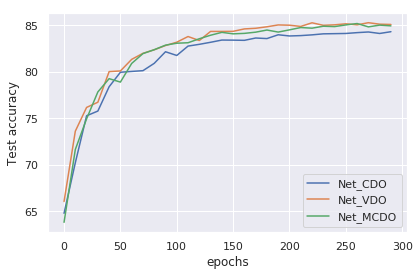

In [16]:
sns.set()
epochs = [10*i for i in range((30))]
plt.plot(epochs, net_scores[:30],label='Net_CDO')
plt.plot(epochs, net_scores[30:60],label='Net_VDO')
plt.plot(epochs, net_scores[60:],label='Net_MCDO')
plt.xlabel('epochs')
plt.ylabel('Test accuracy')
plt.legend()
plt.tight_layout()
plt.show()

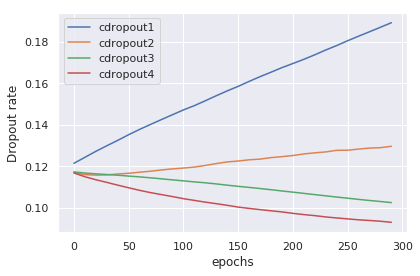

In [17]:
cdropout1_history = [cdropout_history[i][0] for i in range(30)]
cdropout2_history = [cdropout_history[i][1] for i in range(30)]
cdropout3_history = [cdropout_history[i][2] for i in range(30)]
cdropout4_history = [cdropout_history[i][3] for i in range(30)]

plt.plot(epochs, cdropout1_history,label='cdropout1')
plt.plot(epochs, cdropout2_history,label='cdropout2')
plt.plot(epochs, cdropout3_history,label='cdropout3')
plt.plot(epochs, cdropout4_history,label='cdropout4')
plt.xlabel('epochs')
plt.ylabel('Dropout rate')
plt.legend()
plt.tight_layout()
plt.show()

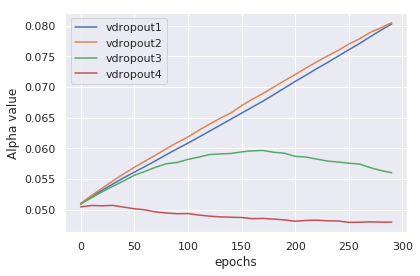

In [18]:
vdropout1_history = [vdropout_history[i][0] for i in range(30)]
vdropout2_history = [vdropout_history[i][1] for i in range(30)]
vdropout3_history = [vdropout_history[i][2] for i in range(30)]
vdropout4_history = [vdropout_history[i][3] for i in range(30)]

plt.plot(epochs, vdropout1_history,label='vdropout1')
plt.plot(epochs, vdropout2_history,label='vdropout2')
plt.plot(epochs, vdropout3_history,label='vdropout3')
plt.plot(epochs, vdropout4_history,label='vdropout4')
plt.xlabel('epochs')
plt.ylabel('Alpha value')
plt.legend()
plt.tight_layout()
plt.show()